## Photo Transfer Learning

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, BatchNormalization, MaxPool2D

#### Read annotation of photographs

In [2]:
df = pd.read_csv('photos.csv')
df.shape

(598, 2)

In [4]:
df.head(3)

,file,score
0,./Arbeit/Genesilico/trainings/project_manageme...,2
1,./Urlaub/2008_Canarife/CIMG1815.JPG,4
2,./Urlaub/2017_08_Gdynia/20170805_115159.jpg,5


#### Helper functions for image preprocessing

In [5]:
def anzeigen(fotos, labels=None):
    plt.figure(figsize=(15,12))
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(fotos[i])
        if labels is not None:
            plt.title(labels[i])
        plt.axis("off")

In [6]:
def image_to_array(fn):
    """Load image and convert it to (224,224,3)"""
    im = Image.open(fn).convert('RGB')
    if im.size[0] > im.size[1]: # breiter als hoch
        target = (224, int(im.size[1] * 224 / im.size[0]))
    else:
        target = (int(im.size[0] * 224 / im.size[1]), 224)
    im = im.resize(target)
    a = np.zeros((224, 224, 3), np.uint8) + 127
    xs, ys = im.size
    x = (224 - xs) // 2
    y = (224 - ys) // 2
    a[y:y+ys, x:x+xs] = np.array(im)
    return a

In [7]:
def bilder_laden(df):
    images = []
    for i, row in df.iterrows():
        a = image_to_array(row['file'])
        images.append(a)
    return images

In [ ]:
gute = df[df['score'] >= 7].sample(3)
anzeigen(bilder_laden(gute))

In [ ]:
schlechte = df[df['score'] <= 2].sample(3)
anzeigen(bilder_laden(schlechte))

## Run pretrained model

In [10]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import decode_predictions
from pprint import pprint

In [11]:
X = np.array(bilder_laden(df))
X = X / 255.0
X.shape

(598, 224, 224, 3)

In [12]:
m = MobileNet(input_shape=(224, 224, 3))
m.compile(optimizer='rmsprop', loss='categorical_crossentropy',
           metrics=['accuracy'])
p = m.predict(X)

In [13]:
p.shape

(598, 1000)

In [14]:
def get_labels(ypred):
    labels, probs = [], []
    for row in decode_predictions(ypred, 1):
        _, label, prob = row[0]
        labels.append(label)
        probs.append(prob)
    return labels, probs

In [15]:
df['label'], df['prob'] = get_labels(p)
df['data'] = list(X)
df['caption'] = df['label'] + ' : ' + df['prob'].round(2).astype(str)

#### Look at some annotations from the 1000 classes

In [16]:
best = df.sort_values(by='prob', ascending=False)
best = best[best['score'] > 4]

In [ ]:
show = best.iloc[:50].sample(3)
anzeigen(show['data'].values, show['caption'].values)

## Vector Transform

In [30]:
base_model = MobileNet(
    include_top=False, # remove the top dense layers
    input_shape=(224,224,3),
    pooling='avg' # average pooling transforms 4d tensor to 2d feature matrix
)

In [31]:
Xfeatures = base_model.predict(X)

In [32]:
Xfeatures.shape # hidden output of some layer in MobileNet (the last CNN or the last pooling)

(598, 1024)

## Ridge
*use the hidden output as input for a second model*

In [34]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score

In [35]:
y = df['score']

In [36]:
m = Ridge(alpha=700.0)
cross_val_score(m, Xfeatures, y, cv=5)  # R^2

array([0.56055973, 0.64293249, 0.6409235 , 0.60428243, 0.68649899])

In [37]:
m.fit(Xfeatures, y)

Ridge(alpha=700.0)

## Prediction on all images (14000+)

In [38]:
import os
import random

def is_image(fn):
    if fn[-3:].lower() in ['png', 'jpg', 'gif']:
        return True

def get_random_image():
    for path, _, files in os.walk('.'):
        for fn in files:
            if not is_image(fn): continue
            # sample
            if random.randint(1, 1000) > 1:
                continue
            a = image_to_array(os.path.join(path, fn))
            return a

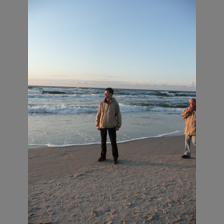

In [39]:
a = get_random_image()
Image.fromarray(a)

In [40]:
a = a / 255.0
a = a.reshape(1, 224, 224, 3)

Xpred = base_model.predict(a) # CNN -> ,1024
m.predict(Xpred)[0]           # Ridge

5.505242

## Find 3 good Photos

In [ ]:
result = []
while len(result) < 3:
    im = get_random_image()
    a = im / 255.0
    a = a.reshape(1, 224, 224, 3)

    Xpred = base_model.predict(a)
    if m.predict(Xpred)[0] > 7.0: #<2.0:#
        result.append(im)
        
anzeigen(result)

### Find 3 bad photos

In [ ]:
result = []
while len(result) < 3:
    im = get_random_image()
    a = im / 255.0
    a = a.reshape(1, 224, 224, 3)

    Xpred = base_model.predict(a)
    if m.predict(Xpred)[0] < 5.0: #<2.0:#
        result.append(im)
        
anzeigen(result)